# Notebook: fine-tune SAM (segment anything) on a custom dataset

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [2]:
!pip install -q datasets

We also install the [Monai](https://github.com/Project-MONAI/MONAI) repository as we'll use a custom loss function from it.

In [3]:
!pip install -q monai

In [4]:
!pip install -q rasterio

## Load dataset

<!-- Here we load a small dataset of 130 (image, ground truth mask) pairs.

To load your own images and masks, refer to the bottom of my [SAM inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Run_inference_with_MedSAM_using_HuggingFace_Transformers.ipynb).

See also [this guide](https://huggingface.co/docs/datasets/image_dataset). -->

In [5]:
import os
from torch.utils.data import Dataset, DataLoader
import skimage.io as io
import matplotlib.pyplot as plt
import cv2

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (string): Directory with all the images and masks.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')
        self.image_names = [f for f in os.listdir(self.images_dir)]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_names[idx])
        mask_name = os.path.join(self.masks_dir, f'mask_{self.image_names[idx].split("_")[1]}')  # Adjust based on your naming convention
        image = plt.imread(img_name)
        mask = plt.imread(mask_name)

        # # resize both image and mask to 256x256
        image = cv2.resize(image, (256, 256))[:, :, :3]
        mask = cv2.resize(mask, (256, 256))
        # mask of size 256x256
        mask = mask[:, :, 0]
        # Convert mask to binary

        sample = {'image': image, 'mask': mask}

        return sample

In [7]:
image_dataset = ImageDataset('/kaggle/input/remotesd/new_dataset')

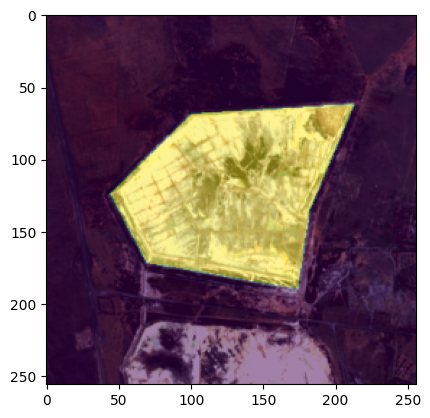

In [8]:
image = image_dataset[2]['image']
mask = image_dataset[2]['mask']

plt.imshow(image)
plt.imshow(mask, alpha=0.5)

In [9]:
# import matplotlib.pyplot as plt
# import numpy as np

# def show_mask(mask, ax, random_color=False):
#     if random_color:
#         color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#     else:
#         color = np.array([30/255, 144/255, 255/255, 0.6])
#     h, w = mask.shape[-2:]
#     mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#     ax.imshow(mask_image)

# fig, axes = plt.subplots()

# # new_image = np.array(image.transpose(1,2,0))
# # new_image = (new_image*255).astype(np.uint8)
# # axes.imshow(Image.fromarray(new_image).resize((256,256)))
# axes.imshow(image)#.transpose(1,2,0))
# ground_truth_seg = np.array(ground_truth_mask)
# show_mask(ground_truth_seg, axes)
# axes.title.set_text(f"Ground truth mask")
# axes.axis("off")

## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

In [10]:
import numpy as np

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [11]:
from torch.utils.data import Dataset
import os
import rasterio
from PIL import Image  # For handling image file operations
from torchvision.transforms import Resize  # For resizing images

class SAMDataset(Dataset):
    def __init__(self, root_dir, processor):
        """
        Args:
            root_dir (string): Directory with all the images and masks.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')
        self.image_names = [f for f in os.listdir(self.images_dir)]
        self.processor = processor

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_names[idx])
        mask_name = os.path.join(self.masks_dir, f'mask_{self.image_names[idx].split("_")[1]}')  # Adjust based on your naming convention
        image = plt.imread(img_name)
        mask = plt.imread(mask_name)

        # # resize both image and mask to 256x256
        image = cv2.resize(image, (256, 256))[:, :, :3]
        mask = cv2.resize(mask, (256, 256))
        # mask of size 256x256
        mask = mask[:, :, 0]

        prompt = get_bounding_box(mask)
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
        inputs["ground_truth_mask"] = mask


        return inputs

In [12]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

2024-03-14 14:38:07.195398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 14:38:07.195523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 14:38:07.319152: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [13]:
train_dataset = SAMDataset(root_dir="/kaggle/input/remotesd/new_dataset", processor=processor)

In [14]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [16]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [17]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

## Load the model

In [18]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

## Train the model

In [19]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [20]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 30

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 493/493 [05:27<00:00,  1.51it/s]


EPOCH: 0
Mean loss: 0.4156258546314665


100%|██████████| 493/493 [05:20<00:00,  1.54it/s]


EPOCH: 1
Mean loss: 0.38015692954614727


100%|██████████| 493/493 [05:17<00:00,  1.56it/s]


EPOCH: 2
Mean loss: 0.374126006152035


100%|██████████| 493/493 [05:17<00:00,  1.56it/s]


EPOCH: 3
Mean loss: 0.3669460172525042


100%|██████████| 493/493 [05:15<00:00,  1.56it/s]


EPOCH: 4
Mean loss: 0.3585925555011564


100%|██████████| 493/493 [05:15<00:00,  1.56it/s]


EPOCH: 5
Mean loss: 0.358470460433989


100%|██████████| 493/493 [05:16<00:00,  1.56it/s]


EPOCH: 6
Mean loss: 0.353391275353896


100%|██████████| 493/493 [05:16<00:00,  1.56it/s]


EPOCH: 7
Mean loss: 0.35158190515051024


100%|██████████| 493/493 [05:16<00:00,  1.56it/s]


EPOCH: 8
Mean loss: 0.3467785124695325


100%|██████████| 493/493 [05:17<00:00,  1.55it/s]


EPOCH: 9
Mean loss: 0.343149581376244


100%|██████████| 493/493 [05:18<00:00,  1.55it/s]


EPOCH: 10
Mean loss: 0.3432657527633419


100%|██████████| 493/493 [05:18<00:00,  1.55it/s]


EPOCH: 11
Mean loss: 0.3386368179810942


100%|██████████| 493/493 [05:17<00:00,  1.55it/s]


EPOCH: 12
Mean loss: 0.3359218534180407


100%|██████████| 493/493 [05:17<00:00,  1.55it/s]


EPOCH: 13
Mean loss: 0.3329499117561576


100%|██████████| 493/493 [05:17<00:00,  1.55it/s]


EPOCH: 14
Mean loss: 0.3329160651437651


100%|██████████| 493/493 [05:15<00:00,  1.56it/s]


EPOCH: 15
Mean loss: 0.32883456603266886


100%|██████████| 493/493 [05:17<00:00,  1.55it/s]


EPOCH: 16
Mean loss: 0.3297624721609313


100%|██████████| 493/493 [05:18<00:00,  1.55it/s]


EPOCH: 17
Mean loss: 0.3289204051842796


100%|██████████| 493/493 [05:18<00:00,  1.55it/s]


EPOCH: 18
Mean loss: 0.3240404327760845


100%|██████████| 493/493 [05:18<00:00,  1.55it/s]


EPOCH: 19
Mean loss: 0.32295029723740976


100%|██████████| 493/493 [05:19<00:00,  1.54it/s]


EPOCH: 20
Mean loss: 0.3216713063464203


100%|██████████| 493/493 [05:20<00:00,  1.54it/s]


EPOCH: 21
Mean loss: 0.320580648964849


100%|██████████| 493/493 [05:21<00:00,  1.54it/s]


EPOCH: 22
Mean loss: 0.3215973846176091


100%|██████████| 493/493 [05:19<00:00,  1.54it/s]


EPOCH: 23
Mean loss: 0.31829882564276274


100%|██████████| 493/493 [05:18<00:00,  1.55it/s]


EPOCH: 24
Mean loss: 0.31432085512980484


100%|██████████| 493/493 [05:19<00:00,  1.54it/s]


EPOCH: 25
Mean loss: 0.31227489069678477


100%|██████████| 493/493 [05:18<00:00,  1.55it/s]


EPOCH: 26
Mean loss: 0.3116484727355336


100%|██████████| 493/493 [05:19<00:00,  1.54it/s]


EPOCH: 27
Mean loss: 0.31075458651744814


100%|██████████| 493/493 [05:21<00:00,  1.54it/s]


EPOCH: 28
Mean loss: 0.309090725881091


100%|██████████| 493/493 [05:21<00:00,  1.53it/s]

EPOCH: 29
Mean loss: 0.309882705596712


In [21]:
# save the model
model.save_pretrained("pretrained_sam_model")

## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

In [22]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(image_dataset[2]["mask"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [23]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [24]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

In [25]:
import matplotlib.pyplot as plt

(-0.5, 255.5, 255.5, -0.5)

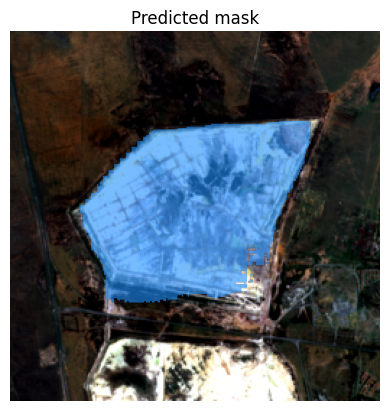

In [26]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()
# new_image = np.array(image.transpose(1,2,0))
# new_image = (new_image*255).astype(np.uint8)
axes.imshow(image)
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

(-0.5, 255.5, 255.5, -0.5)

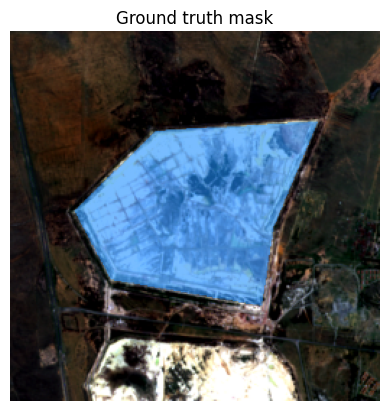

In [27]:
fig, axes = plt.subplots()

axes.imshow(image)
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")